In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset
from experiment import Experiment
from MDP_helpers import calculate_gap

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN, GAT
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.manual_seed(12345)
np.random.seed(12345)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
N_datasets = 100

N_sites = 5
N_species = 20
K = 7

N_states = 3**N_sites

generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False)#, folder="hparam_data")

'Data already exists'

In [6]:
dataset = InMemoryMDPDataset(f"datasets/mdp_{N_states}_state", pre_transform=AllNodeFeatures())

In [16]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [7]:
# hparams = Experiment('gcn_hparams').load()
# hparams = pd.DataFrame(hparams).sort_values(by='score', ascending=False)

In [8]:
# best_params = hparams.loc[21]
# hparams[hparams['lr']>0][0:30]

In [9]:
# best_params

In [10]:
# best_params = {'score': 0.300534,
#  'hidden_channels': 176.0,
#  'num_layers': 1.0,
#  'dropout': 0.004101,
#  'lr': 2.698927,
#  'weight_decay': 0.001483,
#  'gamma': 0.997018}

# best_params = {'hidden_channels': 242, 'num_layers': 1, 'dropout': 0.006388262917827664, 'lr': 2.526232386830896, 'weight_decay': 0.030035363538740922, 'gamma': 0.9342259989713417}

In [11]:
best_params = {'score': 0.3005344048681545,
 'hidden_channels': 176.0,
 'num_layers': 1.0,
 'dropout': 0.004100687104164412,
 'lr': 2.698927286009522,
 'weight_decay': 0.0014830234258634764,
 'gamma': 0.9970183847892857}

In [12]:
# best_params['gamma'] = 1 - 0.1
# best_params['lr'] = 2

In [13]:
best_params

{'score': 0.3005344048681545,
 'hidden_channels': 176.0,
 'num_layers': 1.0,
 'dropout': 0.004100687104164412,
 'lr': 2.698927286009522,
 'weight_decay': 0.0014830234258634764,
 'gamma': 0.9970183847892857}

In [14]:
#-------------------------------------------------------------------------------------------------------------------#
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)


In [20]:
all_results = defaultdict(lambda : defaultdict(list))
N_epochs = 300

times = defaultdict(float)

for trial_num in range(3):
    trial_name = f"trial_{trial_num}"
    # torch.cuda.manual_seed(trial_num)

    hidden_channels = int(best_params['hidden_channels'])
    num_layers = 1#int(best_params['num_layers'])
    dropout = best_params['dropout']
    lr = best_params['lr']
    weight_decay = best_params['weight_decay']
    gamma = best_params['gamma']

    #-------------------------------------------------------------------------------------------------------------------#
    gcn_model = GCN(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = F.cross_entropy#torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    #-------------------------------------------------------------------------------------------------------------------#
    epochs = tqdm(range(N_epochs))
    for epoch in epochs:
        gcn_model.train()
        optimizer.zero_grad()

        total_loss = 0
        for data in train_data:
            pred = gcn_model(
                x = data.x.to(device),
                edge_index = data.edges.to(device)
            )
            total_loss += loss_function(pred, data.k_labels.to(device))
        
        total_loss /= len(train_data)
        total_loss.backward()
        optimizer.step()
        lr_sheduler.step()

        all_results[trial_name]['training_loss'].append(total_loss.to('cpu').detach().float())

        gcn_model.eval()
        total_gap = 0
        total_error = 0
        total_recall = 0
        test_loss = 0
        for data in test_data:
            pred = gcn_model(
                x = data.x.to(device),
                edge_index = data.edges.to(device)
            )

            pred_k = F.softmax(pred, dim=1).argmax(axis=1)
            test_loss += loss_function(pred, data.k_labels.to(device))
            gap, error = calculate_gap(data.P, data.R, data.V, pred_k, K, device='cpu')
            total_gap += gap
            total_error += error
            total_recall += recall_score(data.k_labels, pred_k.to('cpu'), average="macro")

        total_gap /= len(test_data)
        total_error/=len(test_data)
        total_recall/=len(test_data)
        test_loss /= len(test_data)

    
        all_results[trial_name]['test_loss'].append(test_loss.to('cpu').detach().float())
        all_results[trial_name]['testing_gap'].append(total_gap.to('cpu').detach().float())
        all_results[trial_name]['testing_error'].append(total_error.to('cpu').detach().float())

        epochs.set_description(f"Trial {trial_num}, Epoch {epoch+1}/{N_epochs}, Loss {total_loss:.4f}, Gap {total_gap:.4f}, Recall {total_recall:.4f}")
    #-------------------------------------------------------------------------------------------------------------------#

Trial 0, Epoch 300/300, Loss 0.9022, Gap 0.1888, Recall 0.5953: 100%|██████████| 300/300 [02:29<00:00,  2.00it/s]
Trial 1, Epoch 300/300, Loss 0.9022, Gap 0.1888, Recall 0.5953: 100%|██████████| 300/300 [02:29<00:00,  2.01it/s]
Trial 2, Epoch 300/300, Loss 0.9022, Gap 0.1888, Recall 0.5952: 100%|██████████| 300/300 [02:30<00:00,  1.99it/s]


In [ ]:
# os.mkdir(f"multi_run_{N_states}_states_10_runs")

times = pd.Series(times)
# times.to_csv(f"multi_run_{N_states}_states_10_runs/times.csv")

training_loss = pd.DataFrame({trial_id:all_results[trial_id]['training_loss'] for trial_id in all_results.keys()}).astype(float)
test_loss = pd.DataFrame({trial_id:all_results[trial_id]['test_loss'] for trial_id in all_results.keys()}).astype(float)
test_gap = pd.DataFrame({trial_id:all_results[trial_id]['testing_gap'] for trial_id in all_results.keys()}).astype(float)
test_error = pd.DataFrame({trial_id:all_results[trial_id]['testing_error'] for trial_id in all_results.keys()}).astype(float)

# training_loss.to_csv(f"multi_run_{N_states}_states_10_runs/training_loss.csv")
# test_loss.to_csv(f"multi_run_{N_states}_states_10_runs/test_loss.csv")
# test_gap.to_csv(f"multi_run_{N_states}_states_10_runs/test_gap.csv")
# test_error.to_csv(f"multi_run_{N_states}_states_10_runs/test_error.csv")

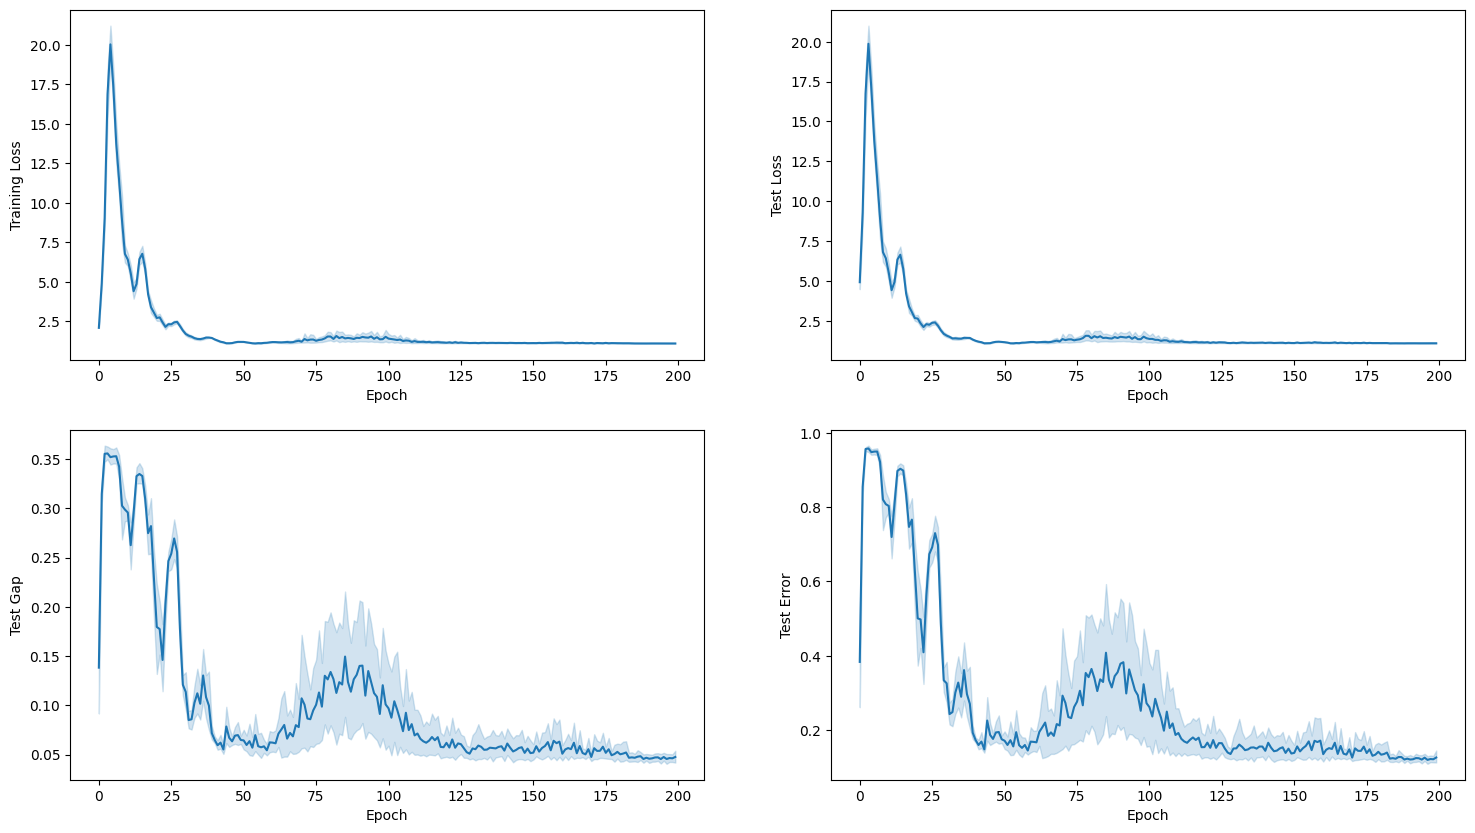

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 10))

training_loss_long = training_loss.stack()
training_loss_long.index = training_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(training_loss_long, errorbar='ci', ax=ax[0, 0])
ax[0, 0].set_ylabel("Training Loss")
ax[0, 0].set_xlabel("Epoch")

test_loss_long = test_loss.stack()
test_loss_long.index = test_loss_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_loss_long, errorbar='ci', ax=ax[0, 1])
ax[0, 1].set_ylabel("Test Loss")
ax[0, 1].set_xlabel("Epoch")


test_gap_long = test_gap.stack()
test_gap_long.index = test_gap_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_gap_long, errorbar='ci', ax=ax[1, 0])
ax[1, 0].set_ylabel("Test Gap")
ax[1, 0].set_xlabel("Epoch")

# ax[1, 0].hlines(np.mean(true_gap), 0, 300)

test_error_long = test_error.stack()
test_error_long.index = test_error_long.index.to_flat_index().map(lambda x: x[0])
sns.lineplot(test_error_long, errorbar='ci', ax=ax[1, 1])
ax[1, 1].set_ylabel("Test Error")
ax[1, 1].set_xlabel("Epoch")
# ax[1, 1].hlines(np.mean(true_error), 0, 300)

# plt.savefig(f"multi_run_{N_states}_states_10_runs/results.png")